# CaCIA Trial - Machine Learning Prediction Models

In [1]:
# Install required packages
!pip install scikit-learn numpy pandas scipy \
joblib threadpoolctl cython \
imbalanced-learn xgboost catboost \
keras tensorflow focal-loss shap \
matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.6 MB/s eta 0:00:00


In [4]:
import sys
import sklearn, numpy, pandas, scipy, joblib, threadpoolctl, cython
import imblearn, xgboost, catboost, keras, tensorflow, shap, matplotlib, seaborn

print("===== Versão do Python =====")
print(sys.version.split()[0])  # só o número da versão

print("\n===== Versões das bibliotecas =====")
print("scikit-learn :", sklearn.__version__)
print("numpy        :", numpy.__version__)
print("pandas       :", pandas.__version__)
print("scipy        :", scipy.__version__)
print("joblib       :", joblib.__version__)
print("threadpoolctl:", threadpoolctl.__version__)
print("cython       :", cython.__version__)
print("imblearn     :", imblearn.__version__)
print("xgboost      :", xgboost.__version__)
print("catboost     :", catboost.__version__)
print("keras        :", keras.__version__)
print("tensorflow   :", tensorflow.__version__)
print("shap         :", shap.__version__)
print("matplotlib   :", matplotlib.__version__)
print("seaborn      :", seaborn.__version__)

# Pacotes que não expõem __version__ diretamente (como focal-loss) -> usar pip show
print("\n===== Outras bibliotecas =====")
!pip show focal-loss | grep Version


===== Versão do Python =====
3.12.11

===== Versões das bibliotecas =====
scikit-learn : 1.6.1
numpy        : 2.0.2
pandas       : 2.2.2
scipy        : 1.16.1
joblib       : 1.5.1
threadpoolctl: 3.6.0
cython       : 3.0.12
imblearn     : 0.14.0
xgboost      : 3.0.4
catboost     : 1.2.8
keras        : 3.10.0
tensorflow   : 2.19.0
shap         : 0.48.0
matplotlib   : 3.10.0
seaborn      : 0.13.2

===== Outras bibliotecas =====
Version: 0.0.7


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import catboost as cb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

## Data Loading and Preprocessing
### Patient-level train-test split (70:30)

In [ ]:
# Load the data from Excel file
data = pd.read_excel('AllFinal_CaCIA_Prediction_ML.xlsx')

print(f"Dataset shape: {data.shape}")
print(f"Target distribution: {data['ANY FAILURE'].value_counts()}")
print(f"Failure rate: {data['ANY FAILURE'].mean():.1%}")

Dataset shape: (501, 16)
Target distribution: ANY FAILURE
0    439
1     62
Name: count, dtype: int64
Failure rate: 12.4%


In [ ]:
# Patient-level train-test split (70:30 as per CaCIA methodology)
# CORRECTION: Ensures no patient data leakage between train and test sets
unique_n_part = data['N PART'].unique()
train_n_part, test_n_part = train_test_split(unique_n_part, test_size=0.3, random_state=42)

train_data = data[data['N PART'].isin(train_n_part)]
test_data = data[data['N PART'].isin(test_n_part)]

# Separate features and target variable
X_train = train_data.drop(['ANY FAILURE', 'N TEETH', 'N PART'], axis=1)
y_train = train_data['ANY FAILURE']
X_test = test_data.drop(['ANY FAILURE', 'N TEETH', 'N PART'], axis=1)
y_test = test_data['ANY FAILURE']

print(f"Training set: {len(X_train)} samples, {y_train.sum()} failures ({y_train.mean():.1%})")
print(f"Test set: {len(X_test)} samples, {y_test.sum()} failures ({y_test.mean():.1%})")
print(f"Split ratio: {len(X_train)/(len(X_train)+len(X_test)):.1%}:{len(X_test)/(len(X_train)+len(X_test)):.1%}")

Training set: 353 samples, 46 failures (13.0%)
Test set: 148 samples, 16 failures (10.8%)
Split ratio: 70.5%:29.5%


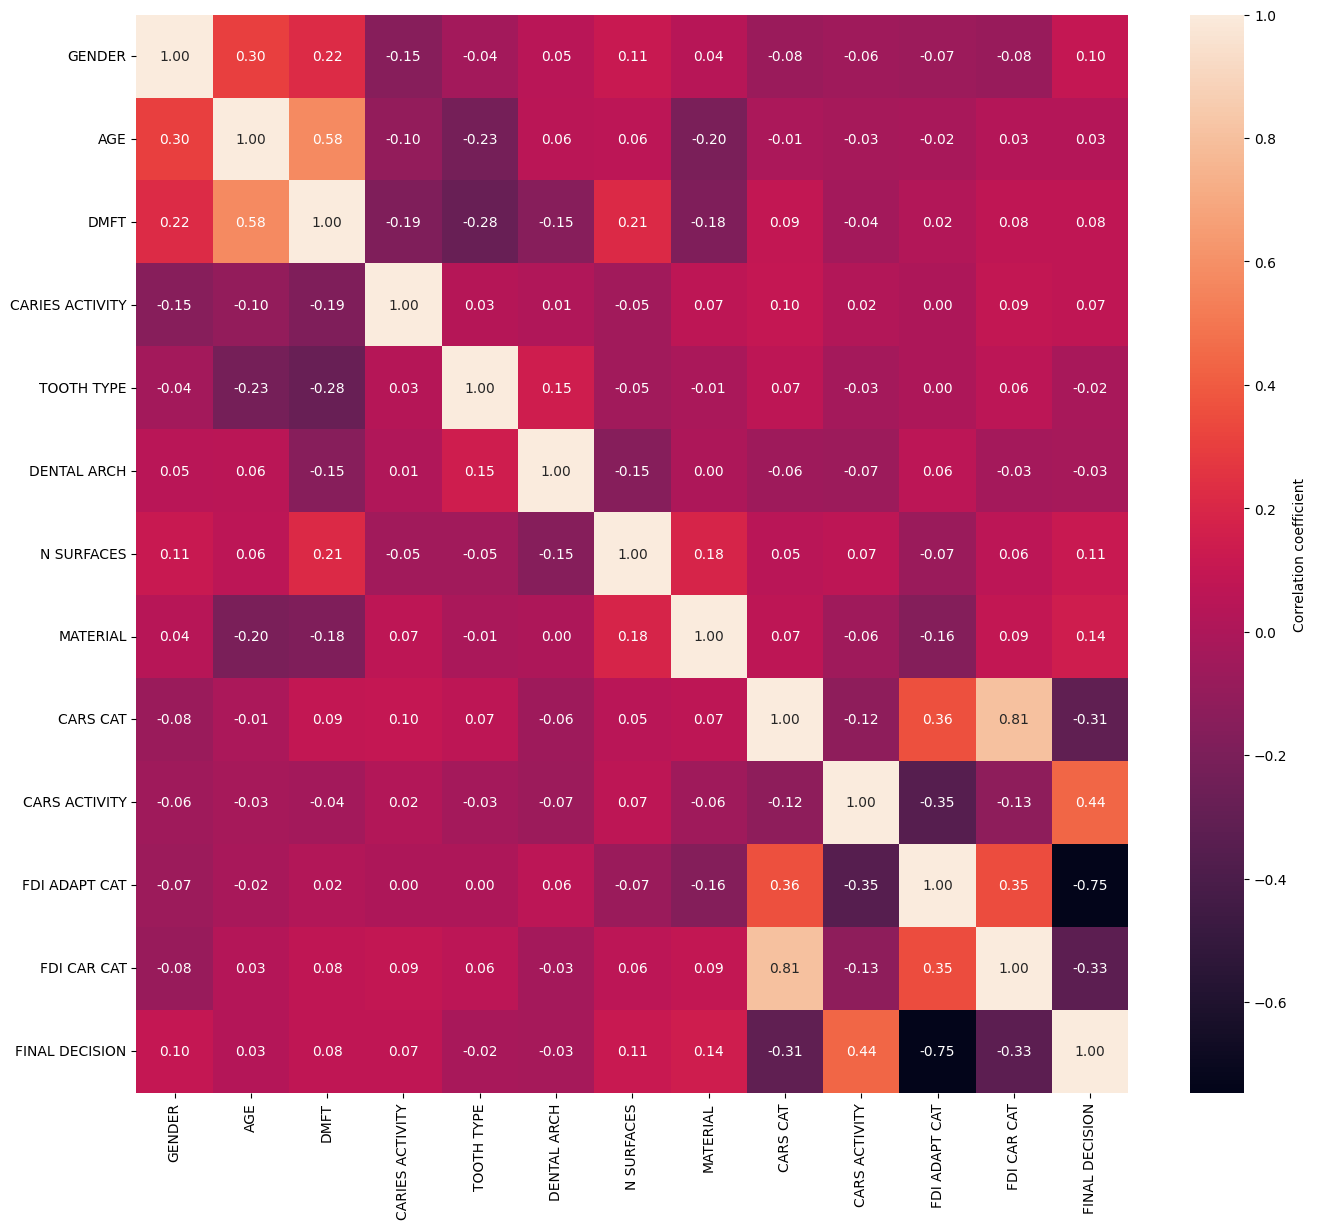

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix of the training data.
# The correlation matrix quantifies the linear relationships between the variables in `X_train`.
corr_matrix = X_train.corr()

# Initialize a matplotlib figure with a specified size (width=16 inches, height=14 inches) for displaying the heatmap.
# This size is chosen to make the heatmap large enough to be easily readable.
plt.figure(figsize=(16, 14))

# Draw the heatmap using seaborn to visualize the correlation matrix.
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 10}, fmt=".2f", cbar_kws={'label': 'Correlation coefficient'})

# Display the plot on the screen. This command is necessary to show the figure when using matplotlib in scripts.
plt.show()

In [ ]:
import pandas as pd

# Define the lists for each variable type
numeric_vars = ['AGE', 'DMFT']
categorical_vars = ['GENDER', 'CARIES ACTIVITY', 'TOOTH TYPE', 'DENTAL ARCH', 'MATERIAL', 'CARS ACTIVITY',
                    'CARS CAT', 'FDI ADAPT CAT', 'FDI CAR CAT', 'ANY FAILURE', 'FINAL DECISION', 'N SURFACES']

def descriptive_statistics(X_train, y_train, X_test, y_test):
    # Merge features and target variable for descriptive statistics on the training set
    train_data_resampled = pd.concat([X_train, y_train], axis=1)

    # Merge features and target variable for descriptive statistics on the test set
    test_data = pd.concat([X_test, y_test], axis=1)

    print("Descriptive Statistics for Numeric Variables:")
    print("\nTraining Set:")
    print(train_data_resampled[numeric_vars].describe())
    print("\nTest Set:")
    print(test_data[numeric_vars].describe())

    stats = {}
    for var in categorical_vars:
        stats[var] = {
            "Training Set": {
                "Count": train_data[var].value_counts().to_dict(),
                "Percentage": (train_data[var].value_counts(normalize=True) * 100).to_dict()
            },
            "Test Set": {
                "Count": test_data[var].value_counts().to_dict(),
                "Percentage": (test_data[var].value_counts(normalize=True) * 100).to_dict()
            }
        }

    # Print Categorical Statistics
    for var, data in stats.items():
        print(f"\n{var} Statistics:")
        for dataset, values in data.items():
            print(f"\n{dataset}:")
            for metric, metric_values in values.items():
                print(f"{metric}: {metric_values}")

# Call the function to display descriptive statistics for the train and test sets
descriptive_statistics(X_train, y_train, X_test, y_test)

Descriptive Statistics for Numeric Variables:

Training Set:
              AGE        DMFT
count  353.000000  353.000000
mean    44.413598   12.626062
std     14.723552    5.977382
min     13.000000    1.000000
25%     34.000000    8.000000
50%     46.000000   12.000000
75%     54.000000   18.000000
max     83.000000   25.000000

Test Set:
              AGE        DMFT
count  148.000000  139.000000
mean    44.479730   15.741007
std     15.275461    7.817055
min     14.000000    1.000000
25%     32.250000   10.000000
50%     46.000000   14.000000
75%     58.000000   24.000000
max     81.000000   29.000000

GENDER Statistics:

Training Set:
Count: {1: 248, 0: 105}
Percentage: {1: 70.25495750708215, 0: 29.745042492917843}

Test Set:
Count: {1: 97, 0: 51}
Percentage: {1: 65.54054054054053, 0: 34.45945945945946}

CARIES ACTIVITY Statistics:

Training Set:
Count: {0: 301, 1: 52}
Percentage: {0: 85.26912181303116, 1: 14.730878186968837}

Test Set:
Count: {0: 114, 1: 34}
Percentage: {0: 77.027

In [ ]:
# Data preprocessing (without SMOTE - will be integrated in pipeline)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Impute missing values in DMFT using median
imputer = SimpleImputer(strategy='median')
X_train['DMFT'] = imputer.fit_transform(X_train[['DMFT']])
X_test['DMFT'] = imputer.transform(X_test[['DMFT']])

# Adjust N SURFACES to 0-4 range for processing
X_train['N SURFACES'] = X_train['N SURFACES'] - 1
X_test['N SURFACES'] = X_test['N SURFACES'] - 1

# Convert categorical variables and apply one-hot encoding
categorical_cols = ['FINAL DECISION', 'CARS CAT', 'FDI ADAPT CAT', 'FDI CAR CAT']
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

one_hot_train = pd.get_dummies(
    X_train[categorical_cols],
    prefix=['FINALDECISION', 'CARSCAT', 'FDI_ADAPT_CAT', 'FDI_CAR_CAT']
)
one_hot_test = pd.get_dummies(
    X_test[categorical_cols],
    prefix=['FINALDECISION', 'CARSCAT', 'FDI_ADAPT_CAT', 'FDI_CAR_CAT']
)

# Drop original categorical columns after creating one-hot encoded columns
X_train = X_train.drop(categorical_cols, axis=1)
X_test = X_test.drop(categorical_cols, axis=1)

X_train = pd.concat([X_train, one_hot_train], axis=1)
X_test = pd.concat([X_test, one_hot_test], axis=1)

# Ensure consistent columns between train and test
missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
X_test = X_test[X_train.columns]

# Convert boolean columns to int
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# Scale numerical features
scaler = StandardScaler()
X_train[['AGE', 'DMFT']] = scaler.fit_transform(X_train[['AGE', 'DMFT']])
X_test[['AGE', 'DMFT']] = scaler.transform(X_test[['AGE', 'DMFT']])

# Adjust N SURFACES back to 1-5 range
X_train['N SURFACES'] = X_train['N SURFACES'] + 1
X_test['N SURFACES'] = X_test['N SURFACES'] + 1

# Final data check
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print(f"Final feature shape: {X_train.shape}")
print(f"NaN check - Train: {X_train.isnull().sum().sum()}, Test: {X_test.isnull().sum().sum()}")
print(f"Feature names: {list(X_train.columns)}")


Final feature shape: (353, 21)
NaN check - Train: 0, Test: 0
Feature names: ['GENDER', 'AGE', 'DMFT', 'CARIES ACTIVITY', 'TOOTH TYPE', 'DENTAL ARCH', 'N SURFACES', 'MATERIAL', 'CARS ACTIVITY', 'FINALDECISION_0', 'FINALDECISION_1', 'FINALDECISION_2', 'CARSCAT_0', 'CARSCAT_1', 'CARSCAT_2', 'FDI_ADAPT_CAT_1', 'FDI_ADAPT_CAT_2', 'FDI_ADAPT_CAT_3', 'FDI_CAR_CAT_1', 'FDI_CAR_CAT_2', 'FDI_CAR_CAT_3']


## Utility Functions
### FIXED: Consistent threshold optimization and model evaluation

In [ ]:
# Optimal threshold selection based on F1-score maximization

import numpy as np
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def find_optimal_threshold(y_true, y_proba):
    """Find optimal threshold based on F1-score maximization."""
    thresholds = np.arange(0.1, 1.01, 0.05)
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold


def evaluate_model_with_seeds(pipeline, param_grid, X_train, y_train, X_test, y_test, model_name, n_seeds=10):
    """Evaluate model with multiple seeds for robustness"""
    seeds = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
    all_results = []
    all_predictions = []  # Store all predictions for averaging

    print(f"\nTraining {model_name} with {n_seeds} seeds...")

    for i, seed in enumerate(seeds[:n_seeds]):
        print(f"  Seed {i+1}/{n_seeds}: {seed}")

        # Set random states
        np.random.seed(seed)

        # Update pipeline random states
        pipeline.set_params(**{f'smote__random_state': seed})
        if hasattr(pipeline.named_steps['classifier'], 'random_state'):
            pipeline.set_params(**{f'classifier__random_state': seed})

        # Cross-validation setup
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

        # Grid search with cross-validation
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=0
        )

        # Fit model
        grid_search.fit(X_train, y_train)

        # Get predictions
        y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
        all_predictions.append(y_pred_proba)  # Store for averaging

        # Find optimal threshold
        optimal_threshold = find_optimal_threshold(y_test, y_pred_proba)
        y_pred = (y_pred_proba >= optimal_threshold).astype(int)

        # Calculate metrics
        seed_results = {
            'seed': seed,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'threshold': optimal_threshold,
            'cv_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'model': grid_search.best_estimator_,
            'y_pred_proba': y_pred_proba
        }

        all_results.append(seed_results)

    # Calculate averaged predictions across all seeds
    avg_predictions = np.mean(all_predictions, axis=0)

    # Calculate statistics across seeds
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'threshold', 'cv_score']
    final_results = {}

    for metric in metrics:
        values = [r[metric] for r in all_results]
        final_results[f'{metric}_mean'] = np.mean(values)
        final_results[f'{metric}_std'] = np.std(values)

    # Best individual result (for SHAP analysis)
    best_result = max(all_results, key=lambda x: x['auc'])
    final_results['best_model'] = best_result['model']
    final_results['best_params'] = best_result['best_params']

    # Use averaged predictions for consistent reporting
    final_results['avg_predictions'] = avg_predictions
    final_results['all_results'] = all_results

    return final_results, all_results


def display_model_summary(results, model_name):
    """Display comprehensive model summary with consistent metrics."""
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} RESULTS SUMMARY (10 Seeds)")
    print(f"{'='*60}")

    # Display mean ± std for all metrics
    if 'cv_score_mean' in results:
        print(f"Mean CV F1 Score: {results['cv_score_mean']:.4f} ± {results['cv_score_std']:.4f}")
        print(f"Mean Test AUC: {results['auc_mean']:.4f} ± {results['auc_std']:.4f}")
        print(f"Mean Test F1: {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")
        print(f"Mean Test Accuracy: {results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}")
        print(f"Mean Test Precision: {results['precision_mean']:.4f} ± {results['precision_std']:.4f}")
        print(f"Mean Test Recall: {results['recall_mean']:.4f} ± {results['recall_std']:.4f}")
        print(f"Mean Optimal Threshold: {results['threshold_mean']:.4f} ± {results['threshold_std']:.4f}")

    if 'best_params' in results:
        print(f"Best Parameters: {results['best_params']}")

    # Show threshold evaluation using AVERAGED predictions
    print(f"\nThreshold evaluation using averaged predictions across 10 seeds:")
    avg_predictions = results['avg_predictions']

    # Calculate AUC with averaged predictions
    avg_auc = roc_auc_score(y_test, avg_predictions)
    print(f"AUC with averaged predictions: {avg_auc:.4f}")

    # Find optimal threshold with averaged predictions
    optimal_threshold = find_optimal_threshold(y_test, avg_predictions)
    y_pred_optimal = (avg_predictions >= optimal_threshold).astype(int)

    # Calculate metrics with optimal threshold
    optimal_accuracy = accuracy_score(y_test, y_pred_optimal)
    optimal_precision = precision_score(y_test, y_pred_optimal, zero_division=0)
    optimal_recall = recall_score(y_test, y_pred_optimal, zero_division=0)
    optimal_f1 = f1_score(y_test, y_pred_optimal, zero_division=0)

    print(f"Optimal threshold: {optimal_threshold:.3f}")
    print(f"Performance at optimal threshold:")
    print(f"  Accuracy: {optimal_accuracy:.4f}")
    print(f"  Precision: {optimal_precision:.4f}")
    print(f"  Recall: {optimal_recall:.4f}")
    print(f"  F1-Score: {optimal_f1:.4f}")

    return avg_predictions


## Decision Tree Model
### SMOTE integrated within pipeline + parameter grid + AUC consistency

In [ ]:
# Decision Tree with proper parameter grid and SMOTE integration
print("Training Decision Tree...")

# Create pipeline with SMOTE (prevents data leakage)
dt_pipeline = ImbPipeline([
('smote', SMOTE(sampling_strategy='minority', k_neighbors=5)),
('classifier', DecisionTreeClassifier())
])

# Proper parameter grid with multiple values
dt_param_grid = {
'classifier__max_depth': [5, 10, 15, 20, None],
'classifier__criterion': ['gini', 'entropy'],
'classifier__min_samples_split': [2, 5, 10],
'classifier__min_samples_leaf': [1, 2, 4]
}

print(f"Parameter combinations: {np.prod([len(v) for v in dt_param_grid.values()])}")

# Evaluate with multiple seeds
dt_results, dt_detailed = evaluate_model_with_seeds(
dt_pipeline, dt_param_grid, X_train, y_train, X_test, y_test, 'Decision Tree', n_seeds=10
)

# Display results with fixed AUC consistency
dt_avg_predictions = display_model_summary(dt_results, 'Decision Tree')

Training Decision Tree...
Parameter combinations: 90

Training Decision Tree with 10 seeds...
  Seed 1/10: 40
  Seed 2/10: 41
  Seed 3/10: 42
  Seed 4/10: 43
  Seed 5/10: 44
  Seed 6/10: 45
  Seed 7/10: 46
  Seed 8/10: 47
  Seed 9/10: 48
  Seed 10/10: 49

DECISION TREE RESULTS SUMMARY (10 Seeds)
Mean CV F1 Score: 0.2353 ± 0.0295
Mean Test AUC: 0.5346 ± 0.0745
Mean Test F1: 0.2267 ± 0.0378
Mean Test Accuracy: 0.6020 ± 0.2251
Mean Test Precision: 0.1620 ± 0.0451
Mean Test Recall: 0.5125 ± 0.2335
Mean Optimal Threshold: 0.4900 ± 0.2764
Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}

Threshold evaluation using averaged predictions across 10 seeds:
AUC with averaged predictions: 0.5850
Optimal threshold: 0.650
Performance at optimal threshold:
  Accuracy: 0.8311
  Precision: 0.2857
  Recall: 0.3750
  F1-Score: 0.3243


## Random Forest Model
### SMOTE integrated within pipeline + proper parameter grid + AUC consistency

In [ ]:
# Random Forest with proper parameter grid and SMOTE integration
print("Training Random Forest...")

# Create pipeline with SMOTE
rf_pipeline = ImbPipeline([
('smote', SMOTE(sampling_strategy='minority', k_neighbors=5)),
('classifier', RandomForestClassifier())
])

# Proper parameter grid with multiple values
rf_param_grid = {
'classifier__n_estimators': [100, 200, 300],
'classifier__max_depth': [5, 7, 10],
'classifier__min_samples_split': [2, 5, 10],
'classifier__min_samples_leaf': [1, 2, 4],
'classifier__max_features': ['sqrt']
}

print(f"Parameter combinations: {np.prod([len(v) for v in rf_param_grid.values()])}")

# Evaluate with multiple seeds
rf_results, rf_detailed = evaluate_model_with_seeds(
rf_pipeline, rf_param_grid, X_train, y_train, X_test, y_test, 'Random Forest', n_seeds=10
)

# Display results with fixed AUC consistency
rf_avg_predictions = display_model_summary(rf_results, 'Random Forest')

Training Random Forest...
Parameter combinations: 81

Training Random Forest with 10 seeds...
  Seed 1/10: 40
  Seed 2/10: 41
  Seed 3/10: 42
  Seed 4/10: 43
  Seed 5/10: 44
  Seed 6/10: 45
  Seed 7/10: 46
  Seed 8/10: 47
  Seed 9/10: 48
  Seed 10/10: 49

RANDOM FOREST RESULTS SUMMARY (10 Seeds)
Mean CV F1 Score: 0.1532 ± 0.0282
Mean Test AUC: 0.5862 ± 0.0356
Mean Test F1: 0.2575 ± 0.0482
Mean Test Accuracy: 0.6878 ± 0.1888
Mean Test Precision: 0.2206 ± 0.1008
Mean Test Recall: 0.4562 ± 0.1997
Mean Optimal Threshold: 0.4500 ± 0.0894
Best Parameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}

Threshold evaluation using averaged predictions across 10 seeds:
AUC with averaged predictions: 0.5968
Optimal threshold: 0.450
Performance at optimal threshold:
  Accuracy: 0.7635
  Precision: 0.2121
  Recall: 0.4375
  F1-Score: 0.2857


## XGBoost Model
### SMOTE integrated within pipeline + parameter grid +  AUC consistency

In [ ]:
# XGBoost with proper parameter grid and SMOTE integration
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("Training XGBoost...")

# Create pipeline with SMOTE
xgb_pipeline = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='minority', k_neighbors=5)),
    ('classifier', xgb.XGBClassifier(scale_pos_weight=3, eval_metric='logloss'))
])

# Proper parameter grid with multiple values
xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

print(f"Parameter combinations: {np.prod([len(v) for v in xgb_param_grid.values()])}")

# Evaluate with multiple seeds
xgb_results, xgb_detailed = evaluate_model_with_seeds(
    xgb_pipeline,
    xgb_param_grid,
    X_train, y_train,
    X_test, y_test,
    'XGBoost',
    n_seeds=10
)

# Display results with fixed AUC consistency
xgb_avg_predictions = display_model_summary(xgb_results, 'XGBoost')


Training XGBoost...
Parameter combinations: 81

Training XGBoost with 10 seeds...
  Seed 1/10: 40
  Seed 2/10: 41
  Seed 3/10: 42
  Seed 4/10: 43
  Seed 5/10: 44
  Seed 6/10: 45
  Seed 7/10: 46
  Seed 8/10: 47
  Seed 9/10: 48
  Seed 10/10: 49

XGBOOST RESULTS SUMMARY (10 Seeds)
Mean CV F1 Score: 0.2468 ± 0.0208
Mean Test AUC: 0.6223 ± 0.0306
Mean Test F1: 0.2762 ± 0.0300
Mean Test Accuracy: 0.6831 ± 0.1385
Mean Test Precision: 0.1996 ± 0.0437
Mean Test Recall: 0.5375 ± 0.1837
Mean Optimal Threshold: 0.6400 ± 0.1241
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}

Threshold evaluation using averaged predictions across 10 seeds:
AUC with averaged predictions: 0.6489
Optimal threshold: 0.650
Performance at optimal threshold:
  Accuracy: 0.7635
  Precision: 0.2286
  Recall: 0.5000
  F1-Score: 0.3137


## CatBoost Model
### CORRECTION: SMOTE integrated within pipeline + proper parameter grid + FIXED AUC consistency

In [ ]:
# CatBoost with proper parameter grid and SMOTE integration
print("Training CatBoost...")

# Prepare data for CatBoost (convert categorical columns)
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

# Convert categorical and boolean columns to numeric
for col in X_train_cb.columns:
    if X_train_cb[col].dtype in ['category', 'bool']:
        X_train_cb[col] = X_train_cb[col].astype('int')
        X_test_cb[col] = X_test_cb[col].astype('int')

X_train_cb = X_train_cb.fillna(0)
X_test_cb = X_test_cb.fillna(0)

# Create pipeline with SMOTE
cb_pipeline = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='minority', k_neighbors=5)),
    ('classifier', cb.CatBoostClassifier(verbose=False))
])

# CORRECTION: Proper parameter grid with multiple values
cb_param_grid = {
    'classifier__iterations': [100, 200, 300],
    'classifier__depth': [4, 6, 8],
    'classifier__learning_rate': [0.03, 0.1, 0.2],
    'classifier__l2_leaf_reg': [1, 3, 5]
}

print(f"Parameter combinations: {np.prod([len(v) for v in cb_param_grid.values()])}")

# Evaluate with multiple seeds
cb_results, cb_detailed = evaluate_model_with_seeds(
    cb_pipeline, cb_param_grid, X_train_cb, y_train, X_test_cb, y_test, 'CatBoost', n_seeds=10
)

# Display results with fixed AUC consistency
cb_avg_predictions = display_model_summary(cb_results, 'CatBoost')

Training CatBoost...
Parameter combinations: 81

Training CatBoost with 10 seeds...
  Seed 1/10: 40
  Seed 2/10: 41
  Seed 3/10: 42
  Seed 4/10: 43
  Seed 5/10: 44
  Seed 6/10: 45
  Seed 7/10: 46
  Seed 8/10: 47
  Seed 9/10: 48
  Seed 10/10: 49

CATBOOST RESULTS SUMMARY (10 Seeds)
Mean CV F1 Score: 0.2102 ± 0.0235
Mean Test AUC: 0.6164 ± 0.0349
Mean Test F1: 0.2976 ± 0.0344
Mean Test Accuracy: 0.7318 ± 0.1643
Mean Test Precision: 0.2576 ± 0.0846
Mean Test Recall: 0.4875 ± 0.2161
Mean Optimal Threshold: 0.5700 ± 0.2410
Best Parameters: {'classifier__depth': 8, 'classifier__iterations': 100, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.2}

Threshold evaluation using averaged predictions across 10 seeds:
AUC with averaged predictions: 0.6196
Optimal threshold: 0.550
Performance at optimal threshold:
  Accuracy: 0.8108
  Precision: 0.2500
  Recall: 0.3750
  F1-Score: 0.3000


## Neural Network Model
### CORRECTION: SMOTE applied + multiple seeds evaluation + threshold optimization + FIXED AUC consistency

In [ ]:
# Neural Network with TensorFlow/Keras
# Install focal loss
try:
    from focal_loss import binary_focal_loss
except ImportError:
    !pip install focal-loss
    from focal_loss import binary_focal_loss

In [ ]:
# Custom functions for Neural Network
def f1_weighted(true, pred):
    ground_positives = K.sum(true, axis=0) + K.epsilon()
    pred_positives = K.sum(pred, axis=0) + K.epsilon()
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()

    precision = true_positives / pred_positives
    recall = true_positives / ground_positives

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives)
    weighted_f1 = K.sum(weighted_f1)

    return 1 - weighted_f1

def focal_loss_train(true, pred, pos_weight=.25, gamma=2):
    loss = binary_focal_loss(true, pred, pos_weight=0.5, gamma=2)
    return loss

# Custom model class
class CustomModel(tf.keras.Model):
    def __init__(self, input_shape):
        super(CustomModel, self).__init__()
        self.bn_0 = BatchNormalization()
        self.dense_1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=input_shape)
        self.bn_1 = BatchNormalization()
        self.dropout_1 = Dropout(0.3)
        self.dense_2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))
        self.bn_2 = BatchNormalization()
        self.dropout_2 = Dropout(0.3)
        self.dense_3 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))
        self.bn_3 = BatchNormalization()
        self.dropout_3 = Dropout(0.3)
        self.dense_4 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))
        self.bn_4 = BatchNormalization()
        self.dropout_4 = Dropout(0.3)
        self.dense_5 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))
        self.bn_5 = BatchNormalization()
        self.dropout_5 = Dropout(0.3)
        self.dense_6 = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.bn_0(x)
        first_layer = self.dense_1(x)
        x = self.bn_1(first_layer)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.bn_2(x)
        x = self.dropout_2(x)
        x = self.dense_3(x)
        x = self.bn_3(x)
        x = self.dropout_3(x)
        x = self.dense_4(x)
        x = self.bn_4(x)
        x = self.dropout_4(x)
        residual = Add()([x, first_layer])
        x = self.dense_5(residual)
        x = self.bn_5(x)
        x = self.dropout_5(x)
        x = self.dense_6(x)
        return x

In [ ]:
# Neural Network training with multiple seeds + AUC consistency

# Apply SMOTE to training data for Neural Network
smote_nn = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=5)
X_train_resampled_nn, y_train_resampled_nn = smote_nn.fit_resample(X_train, y_train)

# Convert to numpy arrays for TensorFlow
X_train_nn = X_train_resampled_nn.values.astype('float32')
X_test_nn = X_test.values.astype('float32')
y_train_nn = y_train_resampled_nn.values.astype('float32')
y_test_nn = y_test.values.astype('float32')

print(f"Neural Network data shape: {X_train_nn.shape}")

# Multiple seeds evaluation
seeds = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
nn_all_results = []
nn_all_predictions = []  # Store all predictions for averaging

for i, seed in enumerate(seeds):
    print(f"\nRunning Neural Network evaluation with seed {i+1}/10: {seed}")

    # Set seeds
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Create model
    model = CustomModel(input_shape=(X_train_nn.shape[1],))

    # Compile model
    model.compile(
        optimizer='adam',
        loss=focal_loss_train,
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.001
    )

    # Train model
    history = model.fit(
        X_train_nn, y_train_nn,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # Predictions
    y_test_pred_proba = model.predict(X_test_nn, verbose=0).flatten()
    nn_all_predictions.append(y_test_pred_proba)  # Store for averaging

    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(y_test_nn, y_test_pred_proba)
    y_pred_best = (y_test_pred_proba >= optimal_threshold).astype(int)

    # Calculate metrics
    seed_results = {
        'seed': seed,
        'accuracy': accuracy_score(y_test_nn, y_pred_best),
        'precision': precision_score(y_test_nn, y_pred_best, zero_division=0),
        'recall': recall_score(y_test_nn, y_pred_best, zero_division=0),
        'f1': f1_score(y_test_nn, y_pred_best, zero_division=0),
        'auc': roc_auc_score(y_test_nn, y_test_pred_proba),
        'threshold': optimal_threshold,
        'model': model,
        'y_pred_proba': y_test_pred_proba
    }

    nn_all_results.append(seed_results)

    print(f"Test - Accuracy: {seed_results['accuracy']:.4f}, F1: {seed_results['f1']:.4f}, "
          f"AUC: {seed_results['auc']:.4f}, Threshold: {optimal_threshold:.3f}")

# Calculate averaged predictions across all seeds
nn_avg_predictions = np.mean(nn_all_predictions, axis=0)

# Calculate Neural Network statistics
nn_results = {}
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'threshold']

for metric in metrics:
    values = [r[metric] for r in nn_all_results]
    nn_results[f'{metric}_mean'] = np.mean(values)
    nn_results[f'{metric}_std'] = np.std(values)

# Best model (for SHAP if needed)
best_nn_result = max(nn_all_results, key=lambda x: x['auc'])
nn_results['best_model'] = best_nn_result['model']
nn_results['avg_predictions'] = nn_avg_predictions
nn_results['all_results'] = nn_all_results

# Display Neural Network summary function
def display_nn_summary(results, model_name):
    """Display Neural Network summary."""
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} RESULTS SUMMARY (10 Seeds)")
    print(f"{'='*60}")

    print(f"Mean Test AUC: {results['auc_mean']:.4f} ± {results['auc_std']:.4f}")
    print(f"Mean Test F1: {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")
    print(f"Mean Test Accuracy: {results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}")
    print(f"Mean Test Precision: {results['precision_mean']:.4f} ± {results['precision_std']:.4f}")
    print(f"Mean Test Recall: {results['recall_mean']:.4f} ± {results['recall_std']:.4f}")
    print(f"Mean Optimal Threshold: {results['threshold_mean']:.4f} ± {results['threshold_std']:.4f}")

    # Show threshold evaluation using AVERAGED predictions
    print(f"\nThreshold evaluation using averaged predictions across 10 seeds:")
    avg_predictions = results['avg_predictions']

    # Calculate AUC with averaged predictions
    avg_auc = roc_auc_score(y_test_nn, avg_predictions)
    print(f"AUC with averaged predictions: {avg_auc:.4f}")

    # Find optimal threshold with averaged predictions
    optimal_threshold = find_optimal_threshold(y_test_nn, avg_predictions)
    y_pred_optimal = (avg_predictions >= optimal_threshold).astype(int)

    # Calculate metrics with optimal threshold
    optimal_accuracy = accuracy_score(y_test_nn, y_pred_optimal)
    optimal_precision = precision_score(y_test_nn, y_pred_optimal, zero_division=0)
    optimal_recall = recall_score(y_test_nn, y_pred_optimal, zero_division=0)
    optimal_f1 = f1_score(y_test_nn, y_pred_optimal, zero_division=0)

    print(f"Optimal threshold: {optimal_threshold:.3f}")
    print(f"Performance at optimal threshold:")
    print(f"  Accuracy: {optimal_accuracy:.4f}")
    print(f"  Precision: {optimal_precision:.4f}")
    print(f"  Recall: {optimal_recall:.4f}")
    print(f"  F1-Score: {optimal_f1:.4f}")

    return avg_predictions

# Display results with proper formatting
nn_avg_predictions = display_nn_summary(nn_results, 'Neural Network')

Neural Network data shape: (614, 21)

Running Neural Network evaluation with seed 1/10: 40
Test - Accuracy: 0.5203, F1: 0.2526, AUC: 0.6276, Threshold: 0.350

Running Neural Network evaluation with seed 2/10: 41
Test - Accuracy: 0.7095, F1: 0.3175, AUC: 0.6319, Threshold: 0.300

Running Neural Network evaluation with seed 3/10: 42
Test - Accuracy: 0.7905, F1: 0.3404, AUC: 0.6565, Threshold: 0.400

Running Neural Network evaluation with seed 4/10: 43
Test - Accuracy: 0.6284, F1: 0.2029, AUC: 0.5429, Threshold: 0.350

Running Neural Network evaluation with seed 5/10: 44
Test - Accuracy: 0.7365, F1: 0.2909, AUC: 0.6626, Threshold: 0.400

Running Neural Network evaluation with seed 6/10: 45
Test - Accuracy: 0.7770, F1: 0.3265, AUC: 0.6579, Threshold: 0.400

Running Neural Network evaluation with seed 7/10: 46
Test - Accuracy: 0.6959, F1: 0.2373, AUC: 0.6035, Threshold: 0.400

Running Neural Network evaluation with seed 8/10: 47
Test - Accuracy: 0.1149, F1: 0.1963, AUC: 0.5386, Threshold: 0

## ROC Curves Analysis
### FIXED: ROC curves using averaged predictions for consistency

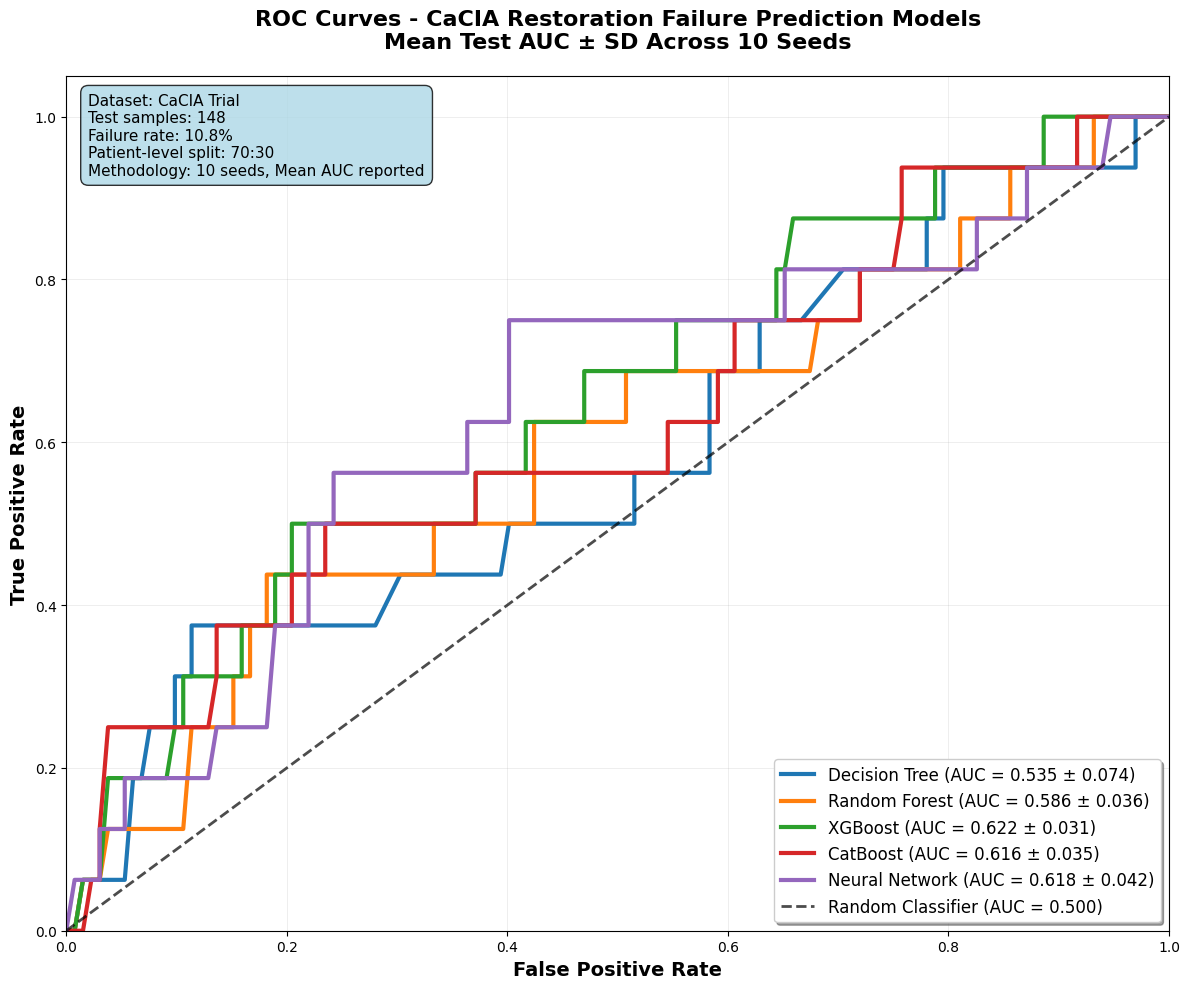

ROC curves saved as 'roc_curves_mean_test_auc.png'

Note: ROC curves now display Mean Test AUC ± SD across 10 seeds in the legend.
Curves are plotted using averaged predictions for smooth visualization.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Create figure for ROC curves
plt.figure(figsize=(12, 10))

# Collect all models and their information
# IMPORTANTE: Agora usamos o auc_mean (média dos AUCs dos 10 seeds) no label
# mas ainda plotamos usando as averaged predictions para ter uma curva suave
models_for_roc = {
    'Decision Tree': {
        'y_pred_proba': dt_avg_predictions,
        'auc_mean': dt_results['auc_mean'],
        'auc_std': dt_results['auc_std']
    },
    'Random Forest': {
        'y_pred_proba': rf_avg_predictions,
        'auc_mean': rf_results['auc_mean'],
        'auc_std': rf_results['auc_std']
    },
    'XGBoost': {
        'y_pred_proba': xgb_avg_predictions,
        'auc_mean': xgb_results['auc_mean'],
        'auc_std': xgb_results['auc_std']
    },
    'CatBoost': {
        'y_pred_proba': cb_avg_predictions,
        'auc_mean': cb_results['auc_mean'],
        'auc_std': cb_results['auc_std']
    },
    'Neural Network': {
        'y_pred_proba': nn_avg_predictions,
        'auc_mean': nn_results['auc_mean'],
        'auc_std': nn_results['auc_std']
    }
}

# Plot ROC curve for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, (name, model_info) in enumerate(models_for_roc.items()):
    # Calcular FPR e TPR usando averaged predictions (para ter curva suave)
    fpr, tpr, _ = roc_curve(y_test, model_info['y_pred_proba'])

    # MUDANÇA PRINCIPAL: Usar auc_mean ± auc_std no label ao invés do AUC das averaged predictions
    auc_mean = model_info['auc_mean']
    auc_std = model_info['auc_std']

    plt.plot(fpr, tpr, linewidth=3, color=colors[i],
             label=f'{name} (AUC = {auc_mean:.3f} ± {auc_std:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7, label='Random Classifier (AUC = 0.500)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves - CaCIA Restoration Failure Prediction Models\nMean Test AUC ± SD Across 10 Seeds',
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=12, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Add text box with dataset information
textstr = (
    f'Dataset: CaCIA Trial\n'
    f'Test samples: {len(y_test)}\n'
    f'Failure rate: {y_test.mean():.1%}\n'
    f'Patient-level split: 70:30\n'
    f'Methodology: 10 seeds, Mean AUC reported'
)
props = dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('roc_curves_mean_test_auc.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curves saved as 'roc_curves_mean_test_auc.png'")
print("\nNote: ROC curves now display Mean Test AUC ± SD across 10 seeds in the legend.")
print("Curves are plotted using averaged predictions for smooth visualization.")


## SHAP Analysis
### Feature importance analysis for the best model

In [ ]:
# SHAP Analysis for the best performing model
import shap
from imblearn.over_sampling import SMOTE

# Find best model by mean AUC
all_model_results = {
    'Decision Tree': dt_results,
    'Random Forest': rf_results,
    'XGBoost': xgb_results,
    'CatBoost': cb_results,
    'Neural Network': nn_results
}

best_model_name = max(all_model_results.keys(), key=lambda x: all_model_results[x]['auc_mean'])
best_model = all_model_results[best_model_name]['best_model']

print(f"Creating SHAP analysis for best model: {best_model_name}")
print(f"Best model mean AUC: {all_model_results[best_model_name]['auc_mean']:.3f} ± {all_model_results[best_model_name]['auc_std']:.3f}")

# For Neural Network, we need to use a different approach
if best_model_name == 'Neural Network':
    print("Note: SHAP analysis for Neural Network requires special handling.")
    print("Using best tree-based model for SHAP analysis instead.")

    # Use best tree-based model for SHAP
    tree_models = {k: v for k, v in all_model_results.items() if k != 'Neural Network'}
    best_tree_model_name = max(tree_models.keys(), key=lambda x: tree_models[x]['auc_mean'])
    best_model = tree_models[best_tree_model_name]['best_model']
    best_model_name = best_tree_model_name
    print(f"Using {best_model_name} for SHAP analysis (mean AUC: {tree_models[best_model_name]['auc_mean']:.3f})")

# Apply SMOTE to get the same data the classifier was trained on
smote = SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Get the trained classifier from the pipeline
classifier = best_model.named_steps['classifier']

# Create SHAP explainer
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(classifier)

# Calculate SHAP values for test set (use subset for speed)
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test[:100])  # Use first 100 samples

if isinstance(shap_values, list):
    shap_values = shap_values[1]  # For binary classification, take positive class

print(f"SHAP values shape: {shap_values.shape}")


Creating SHAP analysis for best model: XGBoost
Best model mean AUC: 0.622 ± 0.031
Creating SHAP explainer...
Calculating SHAP values...
SHAP values shape: (100, 21)


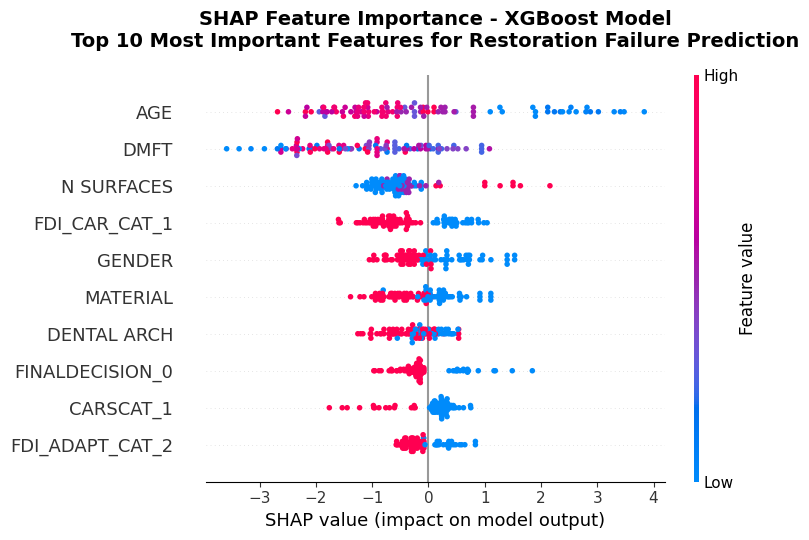

SHAP summary plot saved as 'shap_summary_plot_corrected.png'


In [ ]:
# Create SHAP summary plot (beeswarm plot)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test[:100], max_display=10, show=False)
plt.title(f'SHAP Feature Importance - {best_model_name} Model\nTop 10 Most Important Features for Restoration Failure Prediction',
fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP summary plot saved as 'shap_summary_plot_corrected.png'")

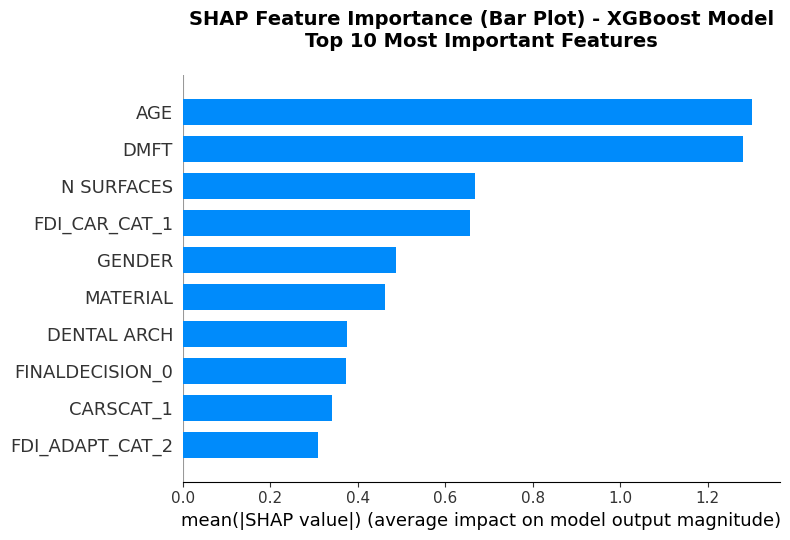

SHAP bar plot saved as 'shap_bar_plot_corrected.png'


In [ ]:
# Create SHAP bar plot (feature importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test[:100], plot_type="bar", max_display=10, show=False)
plt.title(f'SHAP Feature Importance (Bar Plot) - {best_model_name} Model\nTop 10 Most Important Features',
fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_bar_plot_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP bar plot saved as 'shap_bar_plot_corrected.png'")

In [ ]:
# Print top 10 most important features
feature_importance = np.abs(shap_values).mean(0)
feature_names = X_test.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features for {best_model_name}:")
print("="*60)
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Save feature importance
importance_df.to_csv('feature_importance_shap_corrected.csv', index=False)
print("\nFeature importance saved as 'feature_importance_shap_corrected.csv'")



Top 10 most important features for XGBoost:
 1. AGE                       1.3003
 2. DMFT                      1.2807
 3. N SURFACES                0.6681
 4. FDI_CAR_CAT_1             0.6563
 5. GENDER                    0.4869
 6. MATERIAL                  0.4628
 7. DENTAL ARCH               0.3754
 8. FINALDECISION_0           0.3741
 9. CARSCAT_1                 0.3415
10. FDI_ADAPT_CAT_2           0.3095

Feature importance saved as 'feature_importance_shap_corrected.csv'
